In [242]:
import warnings
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torcheval.metrics import R2Score

from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay

from jre_utils.config import asset_types
from jre_utils.datapath import (
    model_ready_data_paths,
    model_output_data_paths,
    DATA_DIRECTORY_PATH,
)
from jre_utils.process import get_most_active_municipalities
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import (
    TimeSeriesTransformerModel,
    TimeSeriesTransformerDecoderModel,
)
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [243]:
# The goal is to have as many factors as possible to help the model discern differences between municipalities with high growth, and municipalities with low growth.

### Config


In [244]:
dataset_asset_type = "combined"
dataset_key = "transactions"
years_ahead = 4

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "robust"
metric = metrics[metric_key]
metric_sharpe = metric + "_sharpe"
normalized_metric_sharpe = metric_sharpe + "_normalized_yearly"

In [245]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

In [246]:
id_columns = ["area_code", "area", "year"]

original_factor_columns = [
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_log_normalize_columns = [
    "population",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = []

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
    # + original_factor_columns
)

final_factor_columns = (
    factor_normalize_columns + factor_log_normalize_columns + factor_columns
)

In [247]:
# asset_types_to_train = list(asset_types.keys())
asset_types_to_train = ["building"]
asset_types_as_factors = list(set(asset_types_to_train + ["building"]))

# Test withour price factors
# core_log_normalize_columns = []
# core_normalize_columns = []
core_log_normalize_columns = ["count", "yearly_price_growth"]
core_normalize_columns = [metric_sharpe]
core_maintain_columns = ["metric_sharpe_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

# combined_core_columns = [
#     f"{asset_type}_{column}"
#     for column in core_columns
#     for asset_type in asset_types_as_factors
# ]

In [248]:
# feature_columns = factor_columns + combined_core_columns + ["land", "condo"]
# extra_prediction_columns = [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]

In [249]:
extra_prediction_columns = []


def get_feature_columns_for_asset_type(asset_type, include_label=True):
    asset_core_columns = [f"{asset_type}_{column}" for column in core_columns]
    return (
        asset_core_columns
        + factor_columns
        + (["land", "condo"] if include_label else [])
    )

In [250]:
def drop_invalid_rows(df, column):
    return df[~df[column].isna()].reset_index(drop=True)

### Dataset Prep


In [299]:
df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)
# df = get_most_active_municipalities(df, count_column=f"population", n=500)

df["area_code"] = df["area_code"].astype(str)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)
# df["weight"] = 1

# Split into Train and Eval
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

train_dfs = {
    asset_type: drop_invalid_rows(train_df, f"{asset_type}_{normalized_metric_sharpe}")
    for asset_type in asset_types_to_train
}

eval_dfs = {
    asset_type: drop_invalid_rows(eval_df, f"{asset_type}_{normalized_metric_sharpe}")
    for asset_type in asset_types_to_train
}

# Finally
df = df.fillna(0)

for asset_type in asset_types_to_train:
    print(
        f"{asset_type} -> Train: {train_dfs[asset_type].shape}, Eval: {eval_dfs[asset_type].shape}"
    )

building -> Train: (10214, 81), Eval: (2222, 81)


<Axes: ylabel='Frequency'>

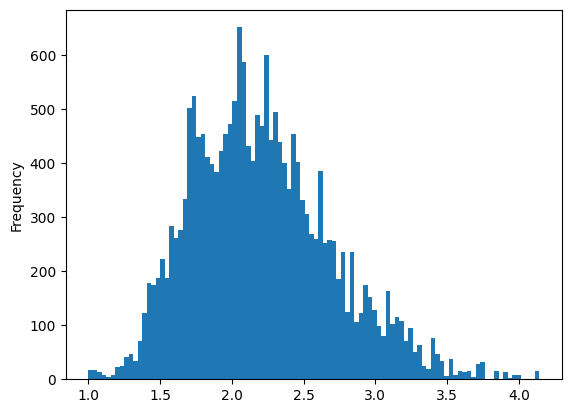

In [300]:
df["weight"].plot.hist(bins=100)

In [301]:
asset_type = "building"
tmp_train_df, tmp_eval_df = train_dfs[asset_type], eval_dfs[asset_type]

tmp_train_df[(tmp_train_df["area_code"] == "13102")][
    ["year", f"{asset_type}_{normalized_metric_sharpe}"]
]

,year,building_robust_price_index_sharpe_normalized_yearly
13,2010,0.127597
243,2011,-0.524783
593,2012,-0.291025
2363,2013,0.857159
3010,2014,3.179896
4132,2015,3.077448
4858,2016,6.424525
5991,2017,6.857898
7512,2018,6.592115
8228,2019,2.536894


In [302]:
tmp_eval_df[(tmp_eval_df["area_code"] == "13102")][
    ["year", f"{asset_type}_{normalized_metric_sharpe}"]
]

,year,building_robust_price_index_sharpe_normalized_yearly
689,2021,1.225365
1400,2022,1.101701


In [303]:
from jre_utils.process import get_window

idx = tmp_eval_df[(tmp_eval_df["area_code"] == "13102")].index[-2]
row = tmp_eval_df.iloc[idx]
target = row[f"{asset_type}_{normalized_metric_sharpe}"]
area_code, year = row["area_code"], row["year"]
window = get_window(df, area_code, year - years_ahead, 5)

print(f"Target: {target}")
window[get_feature_columns_for_asset_type(asset_type, include_label=False)].round(3)
# window

Target: 1.2253654480384495


,building_count_log_normalized_yearly,building_yearly_price_growth_log_normalized_yearly,building_robust_price_index_sharpe_normalized_yearly,building_metric_sharpe_is_available,population_log_normalized_yearly,taxable_income_growth_log_normalized_yearly,taxable_income_per_taxpayer_growth_log_normalized_yearly,net_migration_ratio_log_normalized_yearly,new_dwellings_ratio_log_normalized_yearly,taxpayer_count_growth_log_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available
7866,0.750,0.439,0.857,1.0,1.060,1.041,0.734,3.232,3.046,0.799,1,1,1,1
8588,0.599,0.864,3.180,1.0,1.075,1.929,1.457,4.114,3.523,1.587,1,1,1,1
9865,0.540,0.799,3.077,1.0,1.095,1.181,-0.166,3.537,1.902,2.663,1,1,1,1
10690,0.585,0.476,6.425,1.0,1.110,1.491,0.894,4.079,7.613,1.467,1,1,1,1
11974,0.410,0.624,6.858,1.0,1.130,1.516,0.558,4.132,1.531,1.819,1,1,1,1


In [304]:
# window[["year", "area_code", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [305]:
window_length = 5

In [306]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[f"{asset_type}_{normalized_metric_sharpe}"] + extra_prediction_columns,
    weight_column=f"weight",
    asset_type=asset_type,
    feature_columns=get_feature_columns_for_asset_type(
        asset_type, include_label=len(asset_types_to_train) > 1
    ),
    shift=years_ahead,
    window_length=window_length,
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[f"{asset_type}_{normalized_metric_sharpe}"] + extra_prediction_columns,
    weight_column=f"weight",
    asset_type=asset_type,
    feature_columns=get_feature_columns_for_asset_type(
        asset_type, include_label=len(asset_types_to_train) > 1
    ),
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
    shift=years_ahead,
    window_length=window_length,
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 14) (1,) [-0.05899065] [2.91536697]
1 (1, 14) (1,) [0.65547571] [2.46427549]
2 (1, 14) (1,) [0.06716922] [1.99696687]
3 (1, 14) (1,) [0.27491333] [3.1525325]
0 torch.Size([5, 14]) torch.Size([1]) tensor([-0.0590]) tensor([2.9154])
1 torch.Size([5, 14]) torch.Size([1]) tensor([0.6555]) tensor([2.4643])
2 torch.Size([5, 14]) torch.Size([1]) tensor([0.0672]) tensor([1.9970])
3 torch.Size([5, 14]) torch.Size([1]) tensor([0.2749]) tensor([3.1525])


In [307]:
BATCH_SIZE = 256

In [308]:
train_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        train_dfs[asset_type],
        metrics=[f"{asset_type}_{normalized_metric_sharpe}"] + extra_prediction_columns,
        weight_column=f"weight",
        asset_type=asset_type,
        feature_columns=get_feature_columns_for_asset_type(
            asset_type, include_label=len(asset_types_to_train) > 1
        ),
        transform=transforms.Compose(
            [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
        ),
        shift=years_ahead,
        window_length=window_length,
    )
    for asset_type in asset_types_to_train
}

eval_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        eval_dfs[asset_type],
        metrics=[f"{asset_type}_{normalized_metric_sharpe}"] + extra_prediction_columns,
        weight_column=f"weight",
        asset_type=asset_type,
        feature_columns=get_feature_columns_for_asset_type(
            asset_type, include_label=len(asset_types_to_train) > 1
        ),
        transform=transforms.Compose(
            [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
        ),
        shift=years_ahead,
        window_length=window_length,
    )
    for asset_type in asset_types_to_train
}

In [309]:
train_dataset = ConcatDataset(list(train_datasets.values()))
eval_dataset = ConcatDataset(list(eval_datasets.values()))

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [310]:
len(train_dataloader)

40

### Building the Transformer Model


In [311]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [312]:
# plot num weights over performance to see if size matters at all (H0: it doesn't matter)
n_features = len(
    get_feature_columns_for_asset_type(
        asset_type, include_label=len(asset_types_to_train) > 1
    )
)
nlayers = 4
nhead = 4
d_model = 32 * nhead
d_hid = 32 * nhead
dropout = 0
enc_dropout = 0

# n_features = len(feature_columns)
# nlayers = 6
# nhead = 6
# d_hid = 64 * nhead
# d_model = 64 * nhead # embedding dimensions
# dropout = 0.1
# enc_dropout = 0


# model = TimeSeriesTransformerModel(
#     n_features=n_features,
#     d_model=d_model,
#     nhead=nhead,
#     d_hid=d_hid,
#     nlayers=nlayers,
#     target_size=len(extra_prediction_columns) + 1,
#     dropout=dropout,
#     enc_dropout=enc_dropout,
#     device=device,
# )

model = TimeSeriesTransformerDecoderModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    target_size=len(extra_prediction_columns) + 1,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)

model = model.to(device)

In [313]:
model.eval()

r2_score = R2Score(device=device)
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)
        r2_score.update(
            outputs[:, 0].unsqueeze(1).to(device),
            batch["target"][:, 0].unsqueeze(1).to(device),  # get the first column
        )

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)

        print("Loss:", loss.item())
        print("R2_score:", r2_score.compute().item())

        break

torch.Size([256, 5, 14]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.4507410526275635
R2_score: -0.0018126964569091797


In [314]:
learning_rate = 3e-4  # 3e-4
weight_decay = 1  # 1
num_epochs = 30

In [315]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear",  # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [316]:
# progress_bar = tqdm(range(num_training_steps))
# 8, 8, 0.1 (4y)

progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 9.4379, Eval Loss: 7.1150
Train R^2: 0.0495, Eval R^2: 0.2199
Epoch: 1
Train Loss: 9.2134, Eval Loss: 7.1755
Train R^2: 0.0728, Eval R^2: 0.2089
Epoch: 2
Train Loss: 9.2381, Eval Loss: 6.8217
Train R^2: 0.0696, Eval R^2: 0.2574
Epoch: 3
Train Loss: 9.0274, Eval Loss: 6.7308
Train R^2: 0.0911, Eval R^2: 0.2684
Epoch: 4
Train Loss: 8.7084, Eval Loss: 6.8101
Train R^2: 0.1217, Eval R^2: 0.2585
Epoch: 5
Train Loss: 8.4076, Eval Loss: 6.9427
Train R^2: 0.1485, Eval R^2: 0.2456
Epoch: 6
Train Loss: 8.1033, Eval Loss: 6.8842
Train R^2: 0.1758, Eval R^2: 0.2560
Epoch: 7
Train Loss: 7.9157, Eval Loss: 6.9772
Train R^2: 0.1934, Eval R^2: 0.2476
Epoch: 8
Train Loss: 7.7991, Eval Loss: 6.9881
Train R^2: 0.2044, Eval R^2: 0.2481
Epoch: 9
Train Loss: 7.7238, Eval Loss: 7.0295
Train R^2: 0.2110, Eval R^2: 0.2454
Epoch: 10
Train Loss: 7.6140, Eval Loss: 6.9460
Train R^2: 0.2215, Eval R^2: 0.2548
Epoch: 11
Train Loss: 7.5427, Eval Loss: 6.9303
Train R^2: 0.2280, Eval R^2: 0.2573
Ep

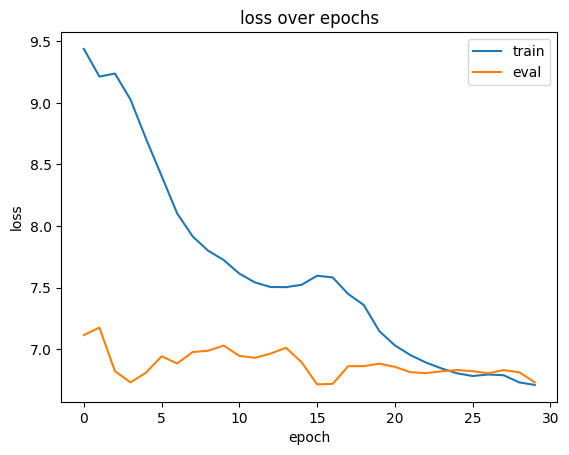

In [317]:
# Plot MSE
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss over epochs")
plt.legend()
plt.show()

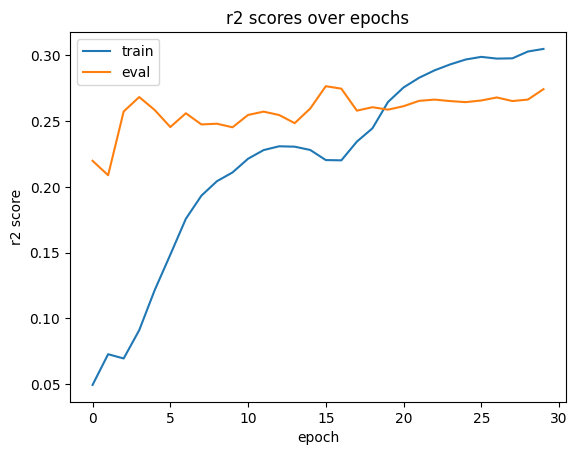

In [318]:
# Plot R2 scores
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

In [275]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 6.6670
Eval R2: 0.2795


In [276]:
dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

# Load and Prepare DFs
df = pd.read_csv(model_ready_data_path)
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

yearly_dataframes = {
    asset_type: {
        f"{year}": drop_invalid_rows(
            df[df["year"] == year], f"{asset_type}_{metric_sharpe}"
        )
        for year in [2021, 2022]
    }
    for asset_type in asset_types_to_train
}

df = df.fillna(0)

for investment_asset_type in asset_types_to_train:
    for year in [2021, 2022]:
        dataset_name = (
            f"sequence_{dataset_key}_{investment_asset_type}_{metric_key}_{years_ahead}"
        )
        output_dataset_name = f"{dataset_name}_{year}"
        model_output_data_path = model_output_data_paths[output_dataset_name]

        prediction_df = yearly_dataframes[investment_asset_type][f"{year}"]

        prediction_df["predicted_normalized_return"] = predict_returns(
            model,
            df,
            prediction_df,
            investment_asset_type,
            get_feature_columns_for_asset_type(investment_asset_type, include_label=False),
            device=device,
        )

        prediction_df["asset_type"] = investment_asset_type
        prediction_df[
            [
                "year",
                "area_code",
                "asset_type",
                "predicted_normalized_return",
                f"{investment_asset_type}_yearly_price_growth",
                f"{investment_asset_type}_{metric_sharpe}",
                f"{investment_asset_type}_{normalized_metric_sharpe}",
            ]
        ].to_csv(model_output_data_path, index=False)

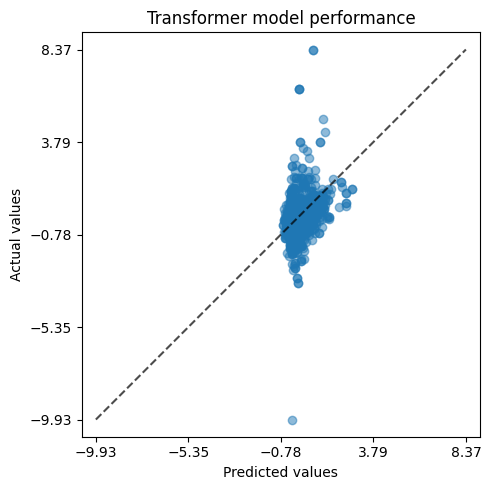

In [277]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[f"{investment_asset_type}_{normalized_metric_sharpe}"],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

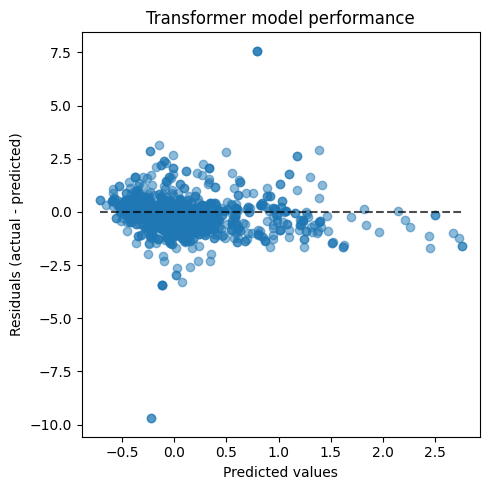

In [278]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[f"{investment_asset_type}_{normalized_metric_sharpe}"],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

In [239]:
model

TimeSeriesTransformerDecoderModel(
  (embedding): Linear(in_features=14, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((128,), eps=1e-05, elementwise_aff

In [240]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 665601
